<i>Copyright (c) Microsoft Corporation. All rights reserved.</i>

<i>Licensed under the MIT License.</i>

# Testing different Hyperparameters and Benchmarking

In this notebook, we'll cover how to test different hyperparameters for a particular dataset and how to benchmark different parameters across a group of datasets. Note that this re-uses functionality which was already introduced and described in the [classification/notebooks/11_exploring_hyperparameters.ipynb](../../classification/notebooks/11_exploring_hyperparameters.ipynb) notebook. **Please refer to that notebook for all explanations, which this notebook will not repeat.**

For an example of how to scale up with remote GPU clusters on Azure Machine Learning, please view [24_exploring_hyperparameters_on_azureml.ipynb](../../classification/notebooks/24_exploring_hyperparameters_on_azureml.ipynb).

## Testing hyperparameters

Ensure edits to libraries are loaded and plotting is shown in the notebook.

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

We start by importing the utilities we need.

In [2]:
import sys
import numpy as np
import scrapbook as sb
import fastai
from fastai.vision import DatasetType

sys.path.append("../../")
from utils_cv.classification.data import Urls
from utils_cv.common.data import unzip_url
from utils_cv.classification.parameter_sweeper import ParameterSweeper, clean_sweeper_df, plot_sweeper_df
from utils_cv.similarity.data import comparative_set_builder
from utils_cv.similarity.metrics import positive_image_ranks
from utils_cv.similarity.model import compute_features_learner

fastai.__version__

'1.0.48'

Define the datasets and parameters we will use in this notebook.

In [3]:
DATA_PATHS = [unzip_url(Urls.fridge_objects_path, exist_ok=True), unzip_url(Urls.fridge_objects_watermark_path, exist_ok=True)]
REPS = 3
LEARNING_RATES = [1e-3, 1e-4, 1e-5]
IM_SIZES = [300, 500]
EPOCHS = [10]

### Similiarity accuracy metric

For image classification, we used the percentage of correctly labeled images to measure accuracy. For image retrieval, our measure is the rank of the positive example among a large number of negatives. This was described in the [01_training_and_evaluation_introduction.ipynb](01_training_and_evaluation_introduction.ipynb) notebook, and we will re-use some of the code from that notebook in the definition of the _retrieval_rank()_ function below.

In [4]:
def retrieval_rank(learn):
    data = learn.data

    # Build multiple sets of comparative images from the validation images
    comparative_sets = comparative_set_builder(
        data.valid_ds, num_sets=1000, num_negatives=99
    )

    # Compute DNN features for all validation images
    embedding_layer = learn.model[1][6]
    valid_features = compute_features_learner(
        data, DatasetType.Valid, learn, embedding_layer
    )

    # For each comparative set compute the distances between the query image and all reference images
    for cs in comparative_sets:
        cs.compute_distances(valid_features)

    # Compute the median rank of the positive example over all comparative sets
    ranks = positive_image_ranks(comparative_sets)
    median_rank = np.median(ranks)
    return median_rank

### Using Python <a name="python"></a>

We start by creating the Parameter Sweeper object. Before we start testing, it's a good idea to see what the default parameters are. We can use a the property `parameters` to easily see those default values.

In [5]:
sweeper = ParameterSweeper()
sweeper.parameters

OrderedDict([('learning_rate', [0.0001]),
             ('epochs', [15]),
             ('batch_size', [16]),
             ('im_size', [299]),
             ('architecture',
              [<Architecture.resnet18: functools.partial(<function resnet18 at 0x7f20f0304d90>)>]),
             ('transform', [True]),
             ('dropout', [0.5]),
             ('weight_decay', [0.01]),
             ('training_schedule',
              [<TrainingSchedule.head_first_then_body: 'head_first_then_body'>]),
             ('discriminative_lr', [False]),
             ('one_cycle_policy', [True]),
             ('metric_name', ['accuracy'])])

Now that we know the defaults, we can pass it the parameters we want to test, and run the parameter sweep.

In [6]:
sweeper.update_parameters(metric_name="rank", learning_rate=LEARNING_RATES, im_size=IM_SIZES, epochs=EPOCHS)
df = sweeper.run(datasets=DATA_PATHS, reps=REPS, metric_fct=retrieval_rank); 
df

this Learner object self-destroyed - it still exists, but no longer usable


duration  \
0 PARAMETERS [learning_rate: 0.0001]|[epochs: 10]... fridgeObjects           18.533702   
                                                     fridgeObjectsWatermark  18.632627   
  PARAMETERS [learning_rate: 0.0001]|[epochs: 10]... fridgeObjects           28.285690   
                                                     fridgeObjectsWatermark  29.570070   
  PARAMETERS [learning_rate: 0.001]|[epochs: 10]|... fridgeObjects           16.601082   
                                                     fridgeObjectsWatermark  16.786539   
  PARAMETERS [learning_rate: 0.001]|[epochs: 10]|... fridgeObjects           26.162405   
                                                     fridgeObjectsWatermark  27.747656   
  PARAMETERS [learning_rate: 1e-05]|[epochs: 10]|... fridgeObjects           19.134267   
                                                     fridgeObjectsWatermark  18.817483   
  PARAMETERS [learning_rate: 1e-05]|[epochs: 10]|... fridgeObjects           26.616261   
                                                     fridgeObjectsWatermark  26.554009   
1 PARAMETERS [learning_rate: 0.0001]|[epochs: 10]... fridgeObjects           17.007456   
                                                     fridgeObjectsWatermark  16.881713   
  PARAMETERS [learning_rate: 0.0001]|[epochs: 10]... fridgeObjects           26.060366   
                                                     fridgeObjectsWatermark  26.343519   
  PARAMETERS [learning_rate: 0.001]|[epochs: 10]|... fridgeObjects           16.511847   
                                                     fridgeObjectsWatermark  16.726393   
  PARAMETERS [learning_rate: 0.001]|[epochs: 10]|... fridgeObjects           26.704052   
                                                     fridgeObjectsWatermark  26.474465   
  PARAMETERS [learning_rate: 1e-05]|[epochs: 10]|... fridgeObjects           16.821825   
                                                     fridgeObjectsWatermark  17.011597   
  PARAMETERS [learning_rate: 1e-05]|[epochs: 10]|... fridgeObjects           27.167216   
                                                     fridgeObjectsWatermark  27.159333   
2 PARAMETERS [learning_rate: 0.0001]|[epochs: 10]... fridgeObjects           16.742670   
                                                     fridgeObjectsWatermark  16.976075   
  PARAMETERS [learning_rate: 0.0001]|[epochs: 10]... fridgeObjects           27.155263   
                                                     fridgeObjectsWatermark  27.057666   
  PARAMETERS [learning_rate: 0.001]|[epochs: 10]|... fridgeObjects           17.374856   
                                                     fridgeObjectsWatermark  17.979725   
  PARAMETERS [learning_rate: 0.001]|[epochs: 10]|... fridgeObjects           26.813652   
                                                     fridgeObjectsWatermark  26.677025   
  PARAMETERS [learning_rate: 1e-05]|[epochs: 10]|... fridgeObjects           16.765612   
                                                     fridgeObjectsWatermark  16.997138   
  PARAMETERS [learning_rate: 1e-05]|[epochs: 10]|... fridgeObjects           26.529381   
                                                     fridgeObjectsWatermark  26.618948   

                                                                             rank  
0 PARAMETERS [learning_rate: 0.0001]|[epochs: 10]... fridgeObjects           13.0  
                                                     fridgeObjectsWatermark  18.5  
  PARAMETERS [learning_rate: 0.0001]|[epochs: 10]... fridgeObjects           21.0  
                                                     fridgeObjectsWatermark  22.0  
  PARAMETERS [learning_rate: 0.001]|[epochs: 10]|... fridgeObjects            1.0  
                                                     fridgeObjectsWatermark   1.0  
  PARAMETERS [learning_rate: 0.001]|[epochs: 10]|... fridgeObjects            1.0  
                                                     fridgeObjectsWatermark

### Visualize Results <a name="visualize"></a>

When we read in multi-index dataframe, index 0 represents the run number, index 1 represents a single permutation of parameters, and index 2 represents the dataset. To see the results, show the df using the `clean_sweeper_df` helper function. This will display all the hyperparameters in a nice, readable way.

In [7]:
df = clean_sweeper_df(df)

Since we've run our benchmarking over 3 repetitions, we may want to just look at the averages across the different __run numbers__.

In [8]:
df.mean(level=(1,2)).T

P: [learning_rate: 0.0001] [im_size: 300]                         \
                                     fridgeObjects fridgeObjectsWatermark   
duration                                 17.427943              17.496805   
rank                                     13.333333              16.000000   

         P: [learning_rate: 0.0001] [im_size: 500]                         \
                                     fridgeObjects fridgeObjectsWatermark   
duration                                 27.167106              27.657085   
rank                                     20.000000              21.333333   

         P: [learning_rate: 0.001] [im_size: 300]                         \
                                    fridgeObjects fridgeObjectsWatermark   
duration                                16.829262              17.164219   
rank                                     1.000000               1.000000   

         P: [learning_rate: 0.001] [im_size: 500]                         \
                                    fridgeObjects fridgeObjectsWatermark   
duration                                26.560036              26.966382   
rank                                     1.000000               2.000000   

         P: [learning_rate: 1e-05] [im_size: 300]                         \
                                    fridgeObjects fridgeObjectsWatermark   
duration                                17.573901              17.608739   
rank                                    23.333333              24.666667   

         P: [learning_rate: 1e-05] [im_size: 500]                         
                                    fridgeObjects fridgeObjectsWatermark  
duration                                26.770953               26.77743  
rank                                    28.666667               27.00000

Print the average accuracy over the different runs for each dataset independently.

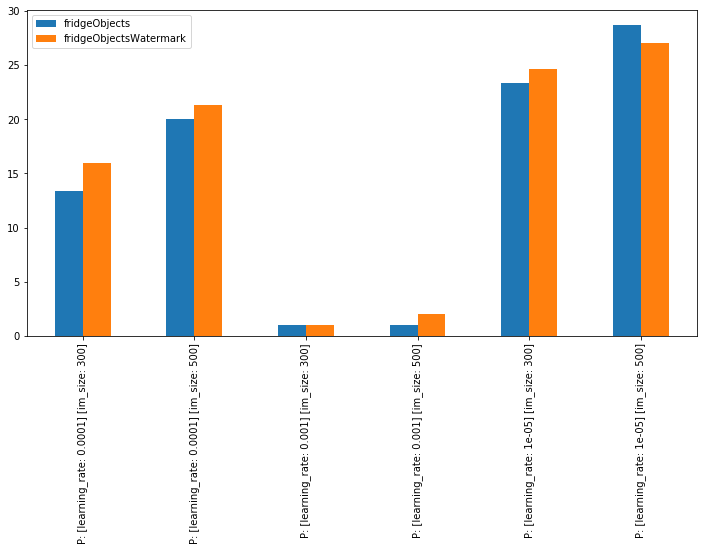

In [9]:
ax = df.mean(level=(1,2))["rank"].unstack().plot(kind='bar', figsize=(12, 6))

Additionally, we may want simply to see which set of hyperparameters perform the best across the different __datasets__. We can do that by averaging the results of the different datasets.

In [10]:
df.mean(level=(1)).T

,P: [learning_rate: 0.0001] [im_size: 300],P: [learning_rate: 0.0001] [im_size: 500],P: [learning_rate: 0.001] [im_size: 300],P: [learning_rate: 0.001] [im_size: 500],P: [learning_rate: 1e-05] [im_size: 300],P: [learning_rate: 1e-05] [im_size: 500]
duration,17.462374,27.412096,16.99674,26.763209,17.59132,26.774191
rank,14.666667,20.666667,1.00000,1.500000,24.00000,27.833333


To make it easier to see which permutation did the best, we can plot the results using the `plot_sweeper_df` helper function. This plot will help us easily see which parameters offer the highest accuracies.

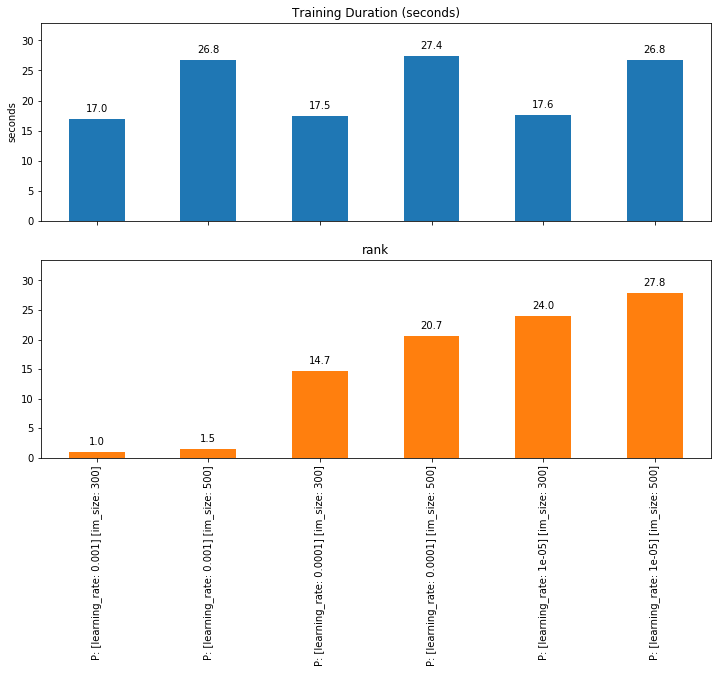

In [11]:
plot_sweeper_df(df.mean(level=(1)), sort_by="rank")

In [12]:
# Preserve some of the notebook outputs
sb.glue("nr_elements", len(df))
sb.glue("ranks", list(df.mean(level=(1))["rank"]))
sb.glue("max_duration", df.max().duration)
sb.glue("min_duration", df.min().duration)